# EDA — Global Crisis Data (procesado)

Este notebook realiza un **Análisis Exploratorio de Datos (EDA)** sobre el dataset ya procesado (`data/processed/global_crisis_data_clean.csv`).

## Objetivos del EDA
1. Verificar **estructura** del dataset (dimensiones, tipos, rangos de año, países).
2. Medir **calidad de datos** (valores nulos, duplicados, columnas constantes).
3. Analizar **distribuciones** y comportamiento de variables numéricas clave.
4. Validar y describir **variables binarias de crisis**.
5. Evidenciar el **tratamiento de outliers** aplicado en el pipeline (recorte por cuantiles).
6. Explorar relaciones simples (crisis vs inflación/crecimiento) y correlaciones numéricas.

> Nota técnica: el proyecto usa una estructura `src/`. En notebooks, agregamos la raíz del proyecto al `sys.path` para poder importar módulos internos.


In [1]:
import sys
from pathlib import Path

# --- Ajuste de ruta para imports del proyecto ---
# Este notebook vive en /notebooks, así que la raíz del proyecto es la carpeta padre.
ROOT = Path().resolve().parent
if str(ROOT) not in sys.path:
    sys.path.append(str(ROOT))

import pandas as pd
import matplotlib.pyplot as plt

from src.estadisticas import reporte_nulos, balance_binaria

RUTA_PROCESADO = Path("../data/processed/global_crisis_data_clean.csv")
df = pd.read_csv(RUTA_PROCESADO)

df.head()

,iso3,year,crisis_next_12m,banking_crisis_next_12m,currency_crisis_next_12m,debt_crisis_next_12m,crisis_any,banking_crisis,currency_crisis,debt_crisis,inflation,gdp_growth,unemployment,fed_funds_rate,real_interest_rate_10y
0,AGO,1960,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3.21,NaN
1,AGO,1961,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,1.95,NaN
2,AGO,1962,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,2.71,NaN
3,AGO,1963,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3.18,NaN
4,AGO,1964,0.0,0.0,0.0,0.0,0,0,0,0,NaN,NaN,NaN,3.50,NaN


## 1) Vista general: dimensiones y tipos

Revisamos la forma del dataset y los tipos de datos para confirmar que el procesamiento dejó las columnas con tipos esperados (por ejemplo, `year` como entero nullable y variables numéricas como `float`).


In [2]:
print("Filas, columnas:", df.shape)
df.dtypes

Filas, columnas: (3864, 15)


iso3                            str
year                          int64
crisis_next_12m             float64
banking_crisis_next_12m     float64
currency_crisis_next_12m    float64
debt_crisis_next_12m        float64
crisis_any                    int64
banking_crisis                int64
currency_crisis               int64
debt_crisis                   int64
inflation                   float64
gdp_growth                  float64
unemployment                float64
fed_funds_rate              float64
real_interest_rate_10y      float64
dtype: object

## 2) Calidad de datos: porcentaje de nulos

Medimos el porcentaje de nulos por columna. Esto permite decidir estrategias posteriores (dejar nulos, imputar, filtrar por disponibilidad, etc.).


In [3]:
reporte_nulos(df).head(15)

,porcentaje_nulos
unemployment,46.25
real_interest_rate_10y,39.29
inflation,14.93
gdp_growth,7.79
iso3,0.00
year,0.00
crisis_next_12m,0.00
crisis_any,0.00
debt_crisis_next_12m,0.00
currency_crisis_next_12m,0.00


## 3) Validaciones básicas: rango de años, países y duplicados

- Verificamos el rango de años (`year`) y número de países (`iso3`).
- Revisamos duplicados por `(iso3, year)` para identificar registros repetidos (idealmente deberían ser 0 o explicables).


In [4]:
print("Años:", int(df["year"].min()), "-", int(df["year"].max()))
print("Países únicos (iso3):", df["iso3"].nunique())

duplicados = df.duplicated(subset=["iso3", "year"]).sum()
print("Duplicados por (iso3, year):", duplicados)

df["iso3"].value_counts().head(10)

Años: 1960 - 2015
Países únicos (iso3): 69
Duplicados por (iso3, year): 0


iso3
AGO    56
ARG    56
AUS    56
AUT    56
BEL    56
BOL    56
BRA    56
CAF    56
CAN    56
CHE    56
Name: count, dtype: int64

## 4) Variables binarias de crisis: distribución y balance

Estas columnas suelen estar desbalanceadas (muchos 0, pocos 1). Revisamos sus frecuencias para:
- detectar columnas constantes (todo 0 o todo 1),
- estimar desbalance,
- decidir métricas/modelos adecuados si más adelante se entrena un clasificador.


In [5]:
cols_binarias = [
    "crisis_next_12m",
    "banking_crisis_next_12m",
    "currency_crisis_next_12m",
    "debt_crisis_next_12m",
    "crisis_any",
    "banking_crisis",
    "currency_crisis",
    "debt_crisis",
]

for c in cols_binarias:
    print(f"\n{c}")
    print(df[c].value_counts(dropna=False))


crisis_next_12m
crisis_next_12m
0.0    2925
1.0     939
Name: count, dtype: int64

banking_crisis_next_12m
banking_crisis_next_12m
0.0    3349
1.0     515
Name: count, dtype: int64

currency_crisis_next_12m
currency_crisis_next_12m
0.0    3864
Name: count, dtype: int64

debt_crisis_next_12m
debt_crisis_next_12m
0.0    3314
1.0     550
Name: count, dtype: int64

crisis_any
crisis_any
0    2924
1     940
Name: count, dtype: int64

banking_crisis
banking_crisis
0    3349
1     515
Name: count, dtype: int64

currency_crisis
currency_crisis
0    3864
Name: count, dtype: int64

debt_crisis
debt_crisis
0    3313
1     551
Name: count, dtype: int64


## 5) Resumen numérico y percentiles (variables clave)

Revisamos estadísticos y percentiles para variables numéricas. Esto es útil para:
- detectar escalas inesperadas,
- confirmar que el recorte de outliers dejó rangos razonables,
- identificar asimetrías fuertes.


In [6]:
cols_num = ["inflation", "gdp_growth", "unemployment", "fed_funds_rate", "real_interest_rate_10y"]
df[cols_num].describe(percentiles=[0.01, 0.05, 0.5, 0.95, 0.99]).T

,count,mean,std,min,1%,5%,50%,95%,99%,max
inflation,3287.0,13.288550,29.335819,-1.187823,-1.187421,0.313821,5.409549,48.676652,228.380975,228.656249
gdp_growth,3563.0,3.864411,3.945371,-9.177334,-9.077038,-3.021537,3.967981,10.220230,14.246496,14.261122
unemployment,2077.0,7.361600,4.623869,0.190000,0.690400,1.863200,6.547000,16.138000,24.727960,31.840000
fed_funds_rate,3864.0,5.255536,3.546271,0.090000,0.090000,0.110000,5.035000,12.240000,16.390000,16.390000
real_interest_rate_10y,2346.0,2.860591,1.775946,-0.013249,-0.013249,0.287844,2.800699,6.637399,6.934689,6.934689


## 6) Distribuciones: inflación y crecimiento del PIB

Graficamos histogramas de:
- `inflation`
- `gdp_growth`

Esto ayuda a ver forma de la distribución (colas largas, concentración, etc.).


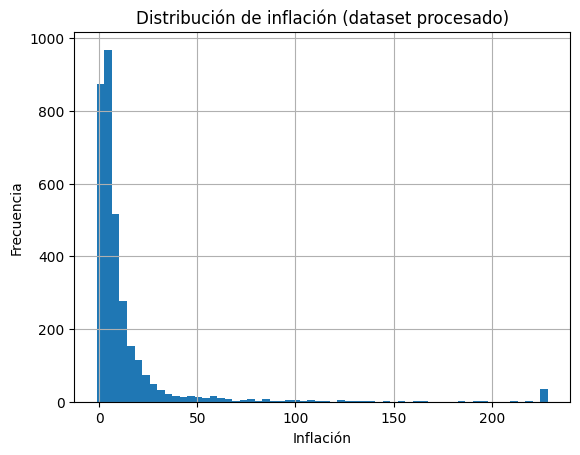

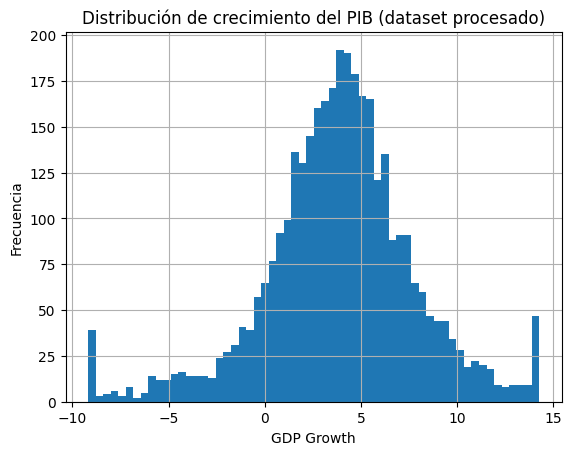

In [7]:
df["inflation"].dropna().hist(bins=60)
plt.title("Distribución de inflación (dataset procesado)")
plt.xlabel("Inflación")
plt.ylabel("Frecuencia")
plt.show()

df["gdp_growth"].dropna().hist(bins=60)
plt.title("Distribución de crecimiento del PIB (dataset procesado)")
plt.xlabel("GDP Growth")
plt.ylabel("Frecuencia")
plt.show()

## 7) Evidencia del tratamiento de outliers (RAW vs PROCESADO)

En el pipeline se aplicó **recorte por cuantiles (1%–99%)** a `inflation` y `gdp_growth`.
Aquí comparamos el máximo en el dataset crudo vs el procesado para mostrar el efecto.


In [8]:
RUTA_RAW = Path("../data/raw/global_crisis_data.csv")
raw = pd.read_csv(RUTA_RAW)

max_raw = pd.to_numeric(raw["inflation"], errors="coerce").max()
max_proc = pd.to_numeric(df["inflation"], errors="coerce").max()

print("Máx inflación RAW:", max_raw)
print("Máx inflación PROCESADO:", max_proc)

Máx inflación RAW: 11749.6396321438
Máx inflación PROCESADO: 228.6562491009658


## 8) Comparación simple: crisis vs inflación/crecimiento

Comparamos estadísticas agregadas (mediana y media) de `inflation` y `gdp_growth` según `crisis_any`.
- La **mediana** es robusta a outliers.
- La **media** es más sensible, pero sirve como referencia.


In [9]:
df.groupby("crisis_any")[["inflation", "gdp_growth"]].median()

,inflation,gdp_growth
crisis_any,,
0,4.773775,4.218941
1,10.370562,2.747904


In [10]:
df.groupby("crisis_any")[["inflation", "gdp_growth"]].mean()

,inflation,gdp_growth
crisis_any,,
0,8.342438,4.294918
1,29.904598,2.547880


## 9) Correlación entre variables numéricas

Calculamos la matriz de correlación para variables numéricas seleccionadas. Esto permite ver relaciones lineales aproximadas y colinealidad potencial.


In [11]:
corr = df[cols_num].corr(numeric_only=True)
corr

,inflation,gdp_growth,unemployment,fed_funds_rate,real_interest_rate_10y
inflation,1.000000,-0.168779,0.065929,0.165780,0.217060
gdp_growth,-0.168779,1.000000,-0.201232,0.003075,-0.060914
unemployment,0.065929,-0.201232,1.000000,-0.083879,0.034722
fed_funds_rate,0.165780,0.003075,-0.083879,1.000000,0.952818
real_interest_rate_10y,0.217060,-0.060914,0.034722,0.952818,1.000000


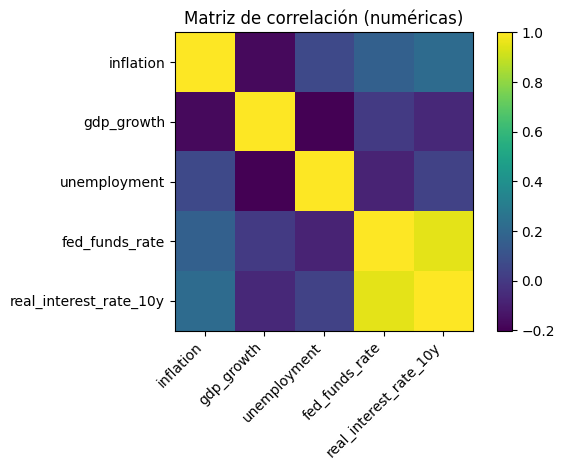

In [12]:
plt.imshow(corr)
plt.xticks(range(len(cols_num)), cols_num, rotation=45, ha="right")
plt.yticks(range(len(cols_num)), cols_num)
plt.title("Matriz de correlación (numéricas)")
plt.colorbar()
plt.tight_layout()
plt.show()

## 10) Conclusiones (para documentar en README)

Completa estas conclusiones con lo que observaste en tu ejecución:

- **Nulos:** columnas con mayor porcentaje de nulos: `unemployment`, `real_interest_rate_10y`, etc. (definir estrategia posterior).
- **Cobertura temporal:** rango de años observado y número de países (`iso3`).
- **Duplicados:** número de duplicados por `(iso3, year)` y decisión (si se eliminan o justifican).
- **Outliers:** evidencia del recorte por cuantiles: `inflation` RAW vs PROCESADO (máximos y/o percentiles).
- **Crisis:** balance de variables binarias (posible desbalance fuerte) y columnas constantes si las hubiera.
- **Relaciones:** diferencias de inflación/crecimiento cuando `crisis_any=1` vs `0` (media/mediana).
